# Analyzing M31 JCMT 850 um image, with dendrogram

import packages

In [1]:
import os
import math
import numpy as np
from astrodendro import Dendrogram, pp_catalog, ppv_catalog
from astrodendro.analysis import PPStatistic
from scipy import linspace, polyval, polyfit, sqrt, stats, randn
from astropy.io import fits
from astropy import units as u
from astropy import constants as con
from astropy.coordinates import SkyCoord
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import aplpy
from astropy.io.fits import getdata
from astropy import wcs
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

/Users/shjiao/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Environmental variable

In [2]:
%matplotlib inline

input parameters

In [3]:
# input FITS image name
infilename = '/Users/shjiao/desktop/check/m31_850/m31_850.beam.fits'

# reading header information
hdulist = fits.open(infilename)

# obtain header parameter
cdelt1 = hdulist[0].header['cdelt1']
crval1 = hdulist[0].header['crval1']
crpix1 = hdulist[0].header['crpix1']
cdelt2 = hdulist[0].header['cdelt2']
crval2 = hdulist[0].header['crval2']
crpix2 = hdulist[0].header['crpix2']

print  cdelt1, crval1, crpix1, cdelt2, crval2, crpix2 

# converting sky coordinates system using the astropy method SkyCoord
c = SkyCoord(ra=crval1*u.degree, dec=crval2*u.degree)
print "Coordinates of reference pixel"
print c.to_string('hmsdms') 

# close FITS file
hdulist.close()

-0.00111111111111 10.6416666667 144.0 0.00111111111111 41.3480555556 127.0
Coordinates of reference pixel
00h42m34s +41d20m53s


preview the continuum fits image

INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -3.049e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.042e-01 [aplpy.core]


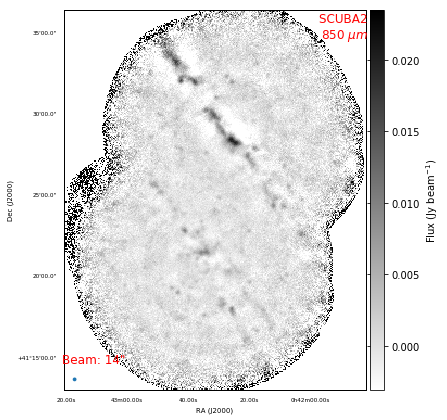

In [6]:
f_850 = aplpy.FITSFigure('/Users/shjiao/desktop/check/m31_850/m31_850.beam.fits', figsize=(7,7))
f_850.show_grayscale()
f_850.add_colorbar()
f_850.colorbar.show()
f_850.recenter(10.6303042,41.41090276,width=0.31,height=0.39)
f_850.colorbar.set_location('right')
f_850.colorbar.set_axis_label_text(r'Flux (Jy beam$^{-1}$)')
f_850.add_label(0.93,0.95, 'SCUBA2 \n850 $\mu m$ ', color='red', relative=True, size='large',layer='source')
f_850.show_colorscale(vmin=-0.00311042,vmax=0.0235,cmap='gist_yarg',stretch='linear')
f_850.add_beam(major=14.*u.arcsecond,minor=14.*u.arcsecond,angle=0.0)
f_850.add_label(0.1, 0.08, 'Beam: 14\"', relative=True, size='large', layer='title',color='red')
f_850.tick_labels.set_font(size='xx-small')
f_850.axis_labels.set_font(size='x-small')

Load the continuum fits image

In [4]:
# load FITS image
sc2_file='/Users/shjiao/desktop/check/m31_850/m31_850.beam.fits'
hdu_sc2=fits.open(sc2_file)
data = hdu_sc2[0].data[0]
nheader = hdu_sc2[0].header

# obtain wcs information from FITS header
wcs = wcs.WCS(nheader)

# Calculate dendrogram

In [18]:
rms = 0.0009  # Jy/beam

min_npix = 8.0

In [20]:
# calculate dendrogram
d = Dendrogram.compute(
                        data, 
                        min_value = rms*3.0, 
                        min_delta = rms, 
                        min_npix  = min_npix,
                        wcs = wcs
                       )

# save the dendrogram
d.save_to('/Users/shjiao/desktop/check/m31_850/m31_dendrogram.hdf5')

# a summary of dendrogram structure
print d.trunk 

[<Structure type=branch idx=6>, <Structure type=leaf idx=1>, <Structure type=leaf idx=2>, <Structure type=leaf idx=7>, <Structure type=leaf idx=8>, <Structure type=leaf idx=9>, <Structure type=leaf idx=10>, <Structure type=leaf idx=11>, <Structure type=leaf idx=15>, <Structure type=leaf idx=16>, <Structure type=leaf idx=12>, <Structure type=leaf idx=13>, <Structure type=branch idx=14>, <Structure type=leaf idx=19>, <Structure type=leaf idx=20>, <Structure type=leaf idx=27>, <Structure type=leaf idx=22>, <Structure type=leaf idx=28>, <Structure type=leaf idx=29>, <Structure type=branch idx=25>, <Structure type=leaf idx=34>, <Structure type=leaf idx=33>, <Structure type=leaf idx=35>, <Structure type=leaf idx=32>, <Structure type=leaf idx=38>, <Structure type=leaf idx=41>, <Structure type=leaf idx=42>, <Structure type=leaf idx=40>, <Structure type=leaf idx=39>, <Structure type=leaf idx=43>, <Structure type=leaf idx=45>, <Structure type=branch idx=47>, <Structure type=leaf idx=50>, <Struct

In [21]:
# loading the saved dendrogram
d = Dendrogram.load_from('/Users/shjiao/desktop/check/m31_850/m31_dendrogram.hdf5')

In [22]:
# making dendrogram structurea a catelogue,
# and print it
metadata = {}
metadata['data_unit'] = u.Jy / u.beam
metadata['spatial_scale'] =  4.0 * u.arcsec # this means the pixel size
metadata['beam_major'] =  14.0 * u.arcsec
metadata['beam_minor'] =  14.0 * u.arcsec

distance = 780.0*1000.0 # parsec
parsec_to_aU = 206264.806247096

print  'CDELT : ', metadata['spatial_scale'], "\n"
print  'BMAJ : ', metadata['beam_major'] 
print  'BMIN : ', metadata['beam_minor'], "\n\n" 
print  'minimum leaf size : ', \
        metadata['spatial_scale'] * min_npix * distance / parsec_to_aU, "[parsec] \n"
print  'minimum leaf area : ', \
        metadata['spatial_scale'] * metadata['spatial_scale'] * min_npix, "\n"

cat = pp_catalog(d, metadata, verbose=False)
cat.pprint(show_unit=True, max_lines=10)

CDELT :  4.0 arcsec 

BMAJ :  14.0 arcsec
BMIN :  14.0 arcsec 


minimum leaf size :  121.009494805 arcsec [parsec] 

minimum leaf area :  128.0 arcsec2 

_idx  area_ellipse area_exact ...     radius        x_cen         y_cen    
        arcsec2     arcsec2   ...     arcsec         pix           pix     
---- ------------- ---------- ... ------------- ------------- -------------
   0 99.3459858974      208.0 ... 4.77613060456  127.58247448 4.96009044704
   1 80.8920607673      208.0 ... 4.30976889014  134.20649059 5.27686157058
 ...           ...        ... ...           ...           ...           ...
 378  515.91146421      976.0 ... 10.8840022141 203.354229875 360.467891792
 379 126.373988031      288.0 ... 5.38678792113 188.874573265 364.056345139
 380 45.4148291969      144.0 ... 3.22923666431 173.497779987   368.4445623
Length = 381 rows


2D plotting for leaf

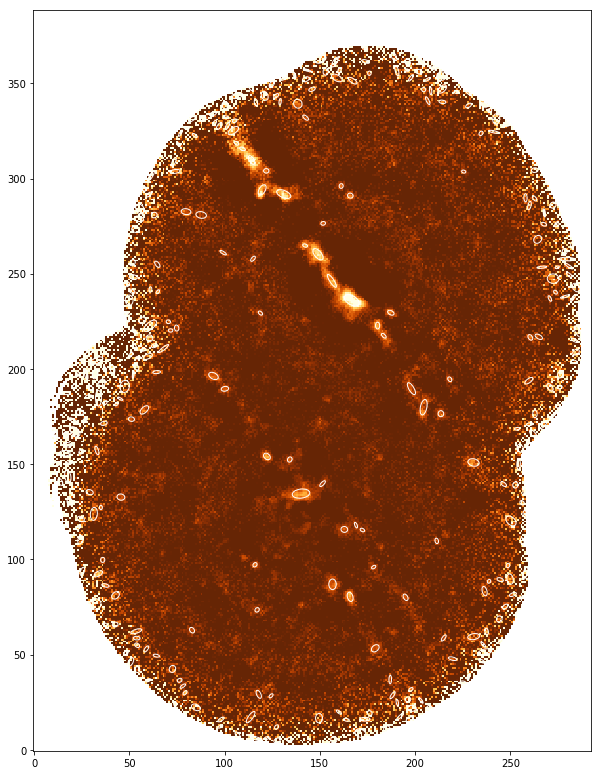

In [23]:
fig = plt.figure(figsize=(10,15))
p3 = d.plotter()
ax1 = fig.add_subplot(1,1,1)
ax1.imshow((data), origin='lower', interpolation='nearest',
          cmap=plt.cm.YlOrBr_r, vmin=0.0002,vmax=0.017)

NH2 = data
NH2_mean = []
for i,leaf in enumerate(d.leaves):
    NH2_mean= np.append(NH2_mean,np.nanmean(NH2[leaf.indices()[0],leaf.indices()[1]]))          
          
for i,leaf in enumerate(d.leaves):
    s = PPStatistic(leaf)
    ellipse = s.to_mpl_ellipse(edgecolor='white', facecolor='none')
    ax1.add_patch(ellipse)
           
#plt.savefig(outpath+r'm31_dendro.pdf')

# try erosion before using dendrogram

In [16]:
from skimage.morphology import disk,erosion,opening

In [17]:
mask=np.isfinite(data)
mask2=erosion(mask, disk(30))
f = data/mask2
NH2 = f

/Users/shjiao/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [49]:
min_npix = 7.0
# calculate dendrogram
d_sec = Dendrogram.compute(
                        f, 
                        min_value = rms*2.0, 
                        min_delta = rms, 
                        min_npix  = min_npix,
                        wcs = wcs
                       )

# save the dendrogram
d_sec.save_to('/Users/shjiao/desktop/check/m31_850/m31_dendrogram.erosion.hdf5')

# a summary of dendrogram structure
print d_sec.trunk 

[<Structure type=leaf idx=0>, <Structure type=leaf idx=1>, <Structure type=leaf idx=2>, <Structure type=leaf idx=4>, <Structure type=leaf idx=3>, <Structure type=leaf idx=5>, <Structure type=leaf idx=7>, <Structure type=leaf idx=8>, <Structure type=leaf idx=9>, <Structure type=leaf idx=11>, <Structure type=leaf idx=10>, <Structure type=leaf idx=12>, <Structure type=leaf idx=6>, <Structure type=leaf idx=14>, <Structure type=leaf idx=15>, <Structure type=leaf idx=17>, <Structure type=branch idx=20>, <Structure type=leaf idx=13>, <Structure type=leaf idx=18>, <Structure type=leaf idx=23>, <Structure type=leaf idx=22>, <Structure type=leaf idx=24>, <Structure type=leaf idx=26>, <Structure type=leaf idx=21>, <Structure type=leaf idx=27>, <Structure type=leaf idx=25>, <Structure type=leaf idx=28>, <Structure type=leaf idx=31>, <Structure type=leaf idx=30>, <Structure type=leaf idx=29>, <Structure type=leaf idx=32>, <Structure type=leaf idx=33>, <Structure type=leaf idx=38>, <Structure type=b

In [57]:
stat = PPStatistic(d_sec.trunk[110],metadata=metadata)
print stat.major_sigma, stat.flux

6.35489249519 arcsec 0.00283615832089 Jy


In [58]:
# making dendrogram structurea a catelogue,
# and print it
metadata = {}
metadata['data_unit'] = u.Jy / u.beam
metadata['spatial_scale'] =  4.0 * u.arcsec # this means the pixel size
metadata['beam_major'] =  14.0 * u.arcsec
metadata['beam_minor'] =  14.0 * u.arcsec

distance = 780.0*1000.0 # parsec
parsec_to_aU = 206264.806247096

print  'CDELT : ', metadata['spatial_scale'], "\n"
print  'BMAJ : ', metadata['beam_major'] 
print  'BMIN : ', metadata['beam_minor'], "\n\n" 
print  'minimum leaf size : ', \
        metadata['spatial_scale'] * min_npix * distance / parsec_to_aU, "[parsec] \n"
print  'minimum leaf area : ', \
        metadata['spatial_scale'] * metadata['spatial_scale'] * min_npix, "\n"

cat_sec = pp_catalog(d_sec, metadata, verbose=False)
cat_sec.pprint(show_unit=True, max_lines=100)

CDELT :  4.0 arcsec 

BMAJ :  14.0 arcsec
BMIN :  14.0 arcsec 


minimum leaf size :  105.883307954 arcsec [parsec] 

minimum leaf area :  112.0 arcsec2 

_idx  area_ellipse area_exact ...     radius        x_cen         y_cen    
        arcsec2     arcsec2   ...     arcsec         pix           pix     
---- ------------- ---------- ... ------------- ------------- -------------
   0           0.0     5008.0 ...           0.0           nan           nan
   1           0.0      688.0 ...           0.0           nan           nan
   2           0.0      160.0 ...           0.0           nan           nan
   3 114.479030027      240.0 ... 5.12700808959 115.020828174 47.4774831963
   4 48.1165020638      112.0 ... 3.32390081575 137.328191681 46.4405715499
   5 33.3677720156      112.0 ... 2.76799076577 169.818187893 46.5522429359
   6           0.0     4976.0 ...           0.0           nan           nan
   7 38.4692626487      112.0 ... 2.97206267253 176.528631906 47.6310035724
   8   23

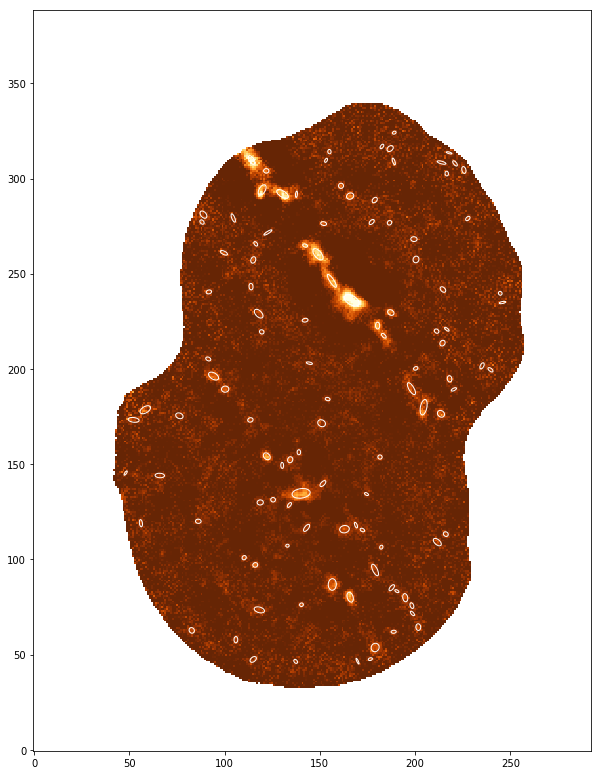

In [39]:
fig = plt.figure(figsize=(10,15))
p3 = d.plotter()
ax1 = fig.add_subplot(1,1,1)
ax1.imshow((f), origin='lower', interpolation='nearest',
          cmap=plt.cm.YlOrBr_r, vmin=0.0002,vmax=0.017)


NH2_mean = []
for i,leaf in enumerate(d_sec.leaves):
    NH2_mean= np.append(NH2_mean,np.nanmean(NH2[leaf.indices()[0],leaf.indices()[1]]))          
          
for i,leaf in enumerate(d_sec.leaves):
    s = PPStatistic(leaf)
    ellipse = s.to_mpl_ellipse(edgecolor='white', facecolor='none')
    ax1.add_patch(ellipse)
           
#plt.savefig(outpath+r'm31_dendro.f.pdf')